## Import Library

In [1]:
import logging
from typing import Dict, Tuple
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split
from kedro.extras.datasets.pickle import PickleDataSet
from sklearn.model_selection import GridSearchCV
import xmltodict
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn


## Load/Save Data (XML/CSV)

In [2]:
def _clean_name (cadena):
    
    cadena_str= str(cadena)
    cadena_str=cadena_str[26:]
    cadena_str = cadena_str.replace('}', '',1)
    cadena_str = cadena_str.replace('\'','')
    
    return cadena_str

In [3]:
def _cambiar_columnas(df):
    
    columnas=len(df.columns)
    i=0
    while (i<columnas):
        df = df.rename(columns={df.columns[i]:i})
        i=i+1
        
        
    return df

In [4]:
def load_from_xml (path):
    xml=open(path, encoding='ISO-8859-1')
    xmldict = xmltodict.parse(xml.read())
    df_enfermedades = pd.DataFrame()
    lista_enfer_sinto_prob=[]
    first_tree=xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]
    id=0
    for nodo in xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]:
     
        enfermedad=_clean_name(nodo["Disorder"]["Name"])
        sec_tree= nodo["Disorder"]["HPODisorderAssociationList"]
        if (len(sec_tree)==2):
            tam_sintomas=len(sec_tree["HPODisorderAssociation"])
            i=0
            registro_enfer_sinto_prob=[]
            while (i<tam_sintomas):
                registro_enfer_sinto_prob.append(enfermedad)
                registro_enfer_sinto_prob.append(id)
                registro_enfer_sinto_prob.append(sec_tree["HPODisorderAssociation"][i]["HPO"]["HPOTerm"])
                frecuencia=_clean_name(sec_tree["HPODisorderAssociation"][i]["HPOFrequency"]["Name"])
                registro_enfer_sinto_prob.append(frecuencia)
                lista_enfer_sinto_prob.append (registro_enfer_sinto_prob)
                registro_enfer_sinto_prob=[]
                i=i+1
        id=id+1
    df_enfermedades = pd.DataFrame(lista_enfer_sinto_prob)
    df_enfermedades = df_enfermedades.rename(columns={0:'Enfermedad',1:'Id_Enfermedad', 2:'Sintoma', 3:"Frecuencia"})
    
    return df_enfermedades        

In [5]:
def save_to_csv (data, path):
    data.to_csv(path, index=False)

In [6]:
def load_from_csv (path):
    data=pd.read_csv(path)
    return data   

## Exploratory Data Analysis (EDA)

In [189]:
def clean_data(data): 
    
    data=data.drop_duplicates()
    data=data.dropna()
    vc = data["Sintoma"].value_counts()
    vector=vc[vc < 50].index
    for a in vector:
        indexNames = data [ data["Sintoma"] == a ].index
        for b in indexNames:
            data.drop(b , inplace=True, axis=0)
  
    return data 

## Feature Engineering 

In [456]:
def selection_and_preparation_data(data):
    
    #data=data[(data['Frecuencia']=="Muy frecuente (99-80%)")]
    data=data[(data['Frecuencia']=="Muy frecuente (99-80%)") | (data['Frecuencia']=="Frecuente (79-30%)")]
    #data=data[(data['Frecuencia']=="Frecuente (79-30%)")]

        
    return data


In [531]:
def generate_data_train (data, repeticiones):
    
    sintomas=data.iloc[:,1]
    sintomas_sin_repe=sintomas.drop_duplicates()
    sintomas_sin_repe=sintomas_sin_repe.sort_values(ascending
                              = True)
    df_train=pd.DataFrame(columns=sintomas_sin_repe)
   # df_train.insert(0, 'Enfermedad', 0)
    #df_train.insert(0, 'id_Enfermedad', 0)
 
    
    data_agrupado = (data.groupby("Enfermedad")
         .agg({"Sintoma": np.array, "Frecuencia": np.array})
         .reset_index()
         )
    
    z=0
    j=0
    while (z<repeticiones):
    
  #  print ("entra")
        i=0
        for a in data_agrupado["Enfermedad"]:
           # print ("Enfermedad: ", a)
        #vector_enfermedad.append(a)
        #lista=[]
            lst = [0] * ((len(sintomas_sin_repe)))
           
            df_train.loc[len(df_train)] = lst
           # df_train["Enfermedad"][j]=a
            #df_train["id_Enfermedad"][j]=(i)
           
            pos=0
            for b in data_agrupado["Sintoma"][i]:
                valor_aleatorio = random.random()
                frecuencia=data_agrupado["Frecuencia"][i][pos]
            #    print ("frecuencia:", frecuencia)
                if (frecuencia=="Muy frecuente (99-80%)"):
             #       print (b)
              #      print ("es muy frecuente")
                    #if (valor_aleatorio>0.4):
                        valor_entero=1
                    #else:
                     #   valor_entero=0
                elif (frecuencia=="Frecuente (79-30%)"):
               #     print (b)
                #    print ("es frecuente")
                    #if (valor_aleatorio>0.6):
                        valor_entero=1
                    #else:
                     #   valor_entero=0
                df_train[b][j]=valor_entero
               
                pos=pos+1
            j=j+1
            i=i+1
        z=z+1
        print ("VUELTA: ", z)
        print ("Tamaño: ",j)
    return df_train      

## Train Data and Predict

In [10]:
def train_data (df_train):
    
    target=df_train["id_Enfermedad"]
   # data=data.drop (['Enfermedad'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train,target)
    rf= RandomForestClassifier()
    rf.fit (X_train,y_train)
    #prediccion=rf.predict(X_test)
    
    return df_train,rf,target,X_test,y_test, X_train, y_train


In [11]:
#def rank (df_train,rf,X_test):
  #  predicciones = rf.predict_proba(X_test)
   # predicciones[:5, :]
   # df_rank = pd.DataFrame(data=predicciones, columns=['0', '1','2','3','4', '5', '6', '7', '8'])
   # df_rank['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
   # return df_rank

## Evaluate

In [12]:
def evaluate (classifier, X_test, y_test):

    y_pred=classifier.predict(X_test)
    probs=classifier.predict_proba(X_test) [:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    pres= precision_score (y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
   # roc_auc = roc_auc_score(y_test,probs, multi_class='ovr')
    #auc = roc_auc_score(y_test, probs)
    print ("Accurancy: ", acc)
    print ("Precision: ", pres)
    print ("f1: ", f1)
    #print ("auc: ", auc)
    
   # fpr, tpr, threshols = roc_curve(y_test, probs)
   # plt.plot(fpr,tpr)
   # plt.xlabel('False positives rate')
   # plt.ylabel('True positives rate')
   # plt.gcf().set_size_inches(8,6)
   

## Notebook Main

In [190]:
df_EnfeySinto=load_from_xml("../data/01_raw/enfermedades.xml")

In [191]:
df_EnfeySinto

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112684,Nevo de cabello lanoso,4263,Brachydactyly,Ocasional (29-5%)
112685,Nevo de cabello lanoso,4263,Widely-spaced incisors,Ocasional (29-5%)
112686,Nevo de cabello lanoso,4263,Persistent pupillary membrane,Ocasional (29-5%)
112687,Nevo de cabello lanoso,4263,Enlarged vestibular aqueduct,Ocasional (29-5%)


In [335]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4262
Sintomas:  8303
Frecuencias:  6


In [257]:
df_EnfeySinto_cleaned=clean_data(df_EnfeySinto)

In [258]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto_cleaned["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto_cleaned["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto_cleaned["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4014
Sintomas:  196
Frecuencias:  6


In [532]:
df_EnfeySinto_select=selection_and_preparation_data(df_EnfeySinto_cleaned)
df_EnfeySinto_select

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112648,Artrogriposis múltiple congénita miogénica aut...,4262,Hyporeflexia,Muy frecuente (99-80%)
112649,Artrogriposis múltiple congénita miogénica aut...,4262,Motor delay,Muy frecuente (99-80%)
112652,Artrogriposis múltiple congénita miogénica aut...,4262,Inability to walk,Muy frecuente (99-80%)
112657,Artrogriposis múltiple congénita miogénica aut...,4262,Cryptorchidism,Frecuente (79-30%)


In [458]:
  print ("Después de borrado filas, duplicates y NAN")
  print ("Enfermedades: ", df_EnfeySinto_select["Enfermedad"].nunique())
  print ("Sintomas: ", df_EnfeySinto_select["Sintoma"].nunique())
  print ("Frecuencias: ", df_EnfeySinto_select["Frecuencia"].nunique())  


Después de borrado filas, duplicates y NAN
Enfermedades:  3728
Sintomas:  196
Frecuencias:  2


In [533]:
df_EnfeySinto_select=df_EnfeySinto_select.drop("Id_Enfermedad", axis=1)
df_EnfeySinto_select

,Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...
112648,Artrogriposis múltiple congénita miogénica aut...,Hyporeflexia,Muy frecuente (99-80%)
112649,Artrogriposis múltiple congénita miogénica aut...,Motor delay,Muy frecuente (99-80%)
112652,Artrogriposis múltiple congénita miogénica aut...,Inability to walk,Muy frecuente (99-80%)
112657,Artrogriposis múltiple congénita miogénica aut...,Cryptorchidism,Frecuente (79-30%)


In [534]:
%%time
df_train_generated=generate_data_train (df_EnfeySinto_select, 1)

VUELTA:  1
Tamaño:  3728
CPU times: user 3.15 s, sys: 15.5 ms, total: 3.17 s
Wall time: 3.17 s


In [535]:
df_train_generated.shape

(3728, 196)

In [536]:
df_Sintomas=df_EnfeySinto_select.groupby (["Sintoma"]).count().reset_index()


In [537]:
df_Sintomas=df_Sintomas.drop(["Enfermedad","Frecuencia"], axis=1)

In [538]:
df_Sintomas.head(50)

,Sintoma
0,Abdominal pain
1,Abnormal blistering of the skin
2,Abnormal facial shape
3,Abnormal heart morphology
4,Abnormal pyramidal sign
5,Abnormality of the dentition
6,Abnormality of the eye
7,Abnormality of the nervous system
8,Absent speech
9,Agenesis of corpus callosum


In [539]:
df_Sintomas[df_Sintomas["Sintoma"]=="Hypotonia"]

,Sintoma
100,Hypotonia


In [540]:
df_Enfermedades=df_EnfeySinto_select.groupby (["Enfermedad"]).count().reset_index()
df_Enfermedades=df_Enfermedades.drop(["Sintoma","Frecuencia"], axis=1)

In [541]:
df_Enfermedades=df_Enfermedades.reset_index()

In [542]:
df_Enfermedades.head(50)

,index,Enfermedad
0,0,AICA ribosiduria
1,1,ALG1-CDG
2,2,ALG11-CDG
3,3,ALG12-CDG
4,4,ALG13-CDG
5,5,ALG2-CDG
6,6,ALG3-CDG
7,7,ALG6-CDG
8,8,ALG8-CDG
9,9,ALG9-CDG


In [543]:
df_Enfermedades.shape


(3728, 2)

In [544]:
df_train_generated=_cambiar_columnas(df_train_generated)


In [545]:
df_train_generated


Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3724,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [546]:
df_matrix=df_train_generated.transpose()

In [547]:
df_matrix

,0,1,2,3,4,5,6,7,8,9,...,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727
Sintoma,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [548]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 3.25%


In [551]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)


In [552]:
ratings_train.shape, ratings_test.shape


((156, 3728), (40, 3728))

In [553]:

n_enfermedades = ratings_train.shape[1]
n_enfermedades
neighbors = NearestNeighbors(n_neighbors=20,
                         metric='cosine')
neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [554]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)
top_k_distances.shape

(156, 20)

In [555]:
#USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
#data = df_users[df_users['username'] == USUARIO_EJEMPLO]
SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data

,Sintoma
34,Cerebral cortical atrophy


In [556]:
#sintoma_ver = (data.iloc[0]['Sintoma']) -1 # resta 1 para obtener el index de pandas
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

34

In [557]:
top_k_distances[sintoma_ver]

array([0.        , 0.8414431 , 0.87957087, 0.88505474, 0.88986214,
       0.89113031, 0.89316401, 0.89491861, 0.89588416, 0.89803745,
       0.90377496, 0.9057191 , 0.90927816, 0.91018996, 0.91188316,
       0.91269841, 0.91283727, 0.91302292, 0.91464208, 0.91613007])

In [558]:
top_k_users.shape

(156, 20)

In [559]:
res = top_k_users[sintoma_ver]
res

array([ 34, 126,  62,  81,  91, 104,  33,  31,  50,  32, 138, 139,  94,
        96, 107,  26, 108,  20, 133,  78])

In [560]:
for a_index in res:
    print(df_Enfermedades[df_Enfermedades['index'] == (a_index)])

    index                          Enfermedad
34     34  Aciduria 3-metilglutacónica tipo 9
     index         Enfermedad
126    126  Anemia falciforme
    index                       Enfermedad
62     62  Adenoma hipofisario no secretor
    index                           Enfermedad
81     81  Albinismo cutáneo, fenotipo Hermine
    index                     Enfermedad
91     91  Albinismo oculocutáneo tipo 6
     index                   Enfermedad
104    104  Amiloidosis ABeta tipo Iowa
    index                          Enfermedad
33     33  Aciduria 3-metilglutacónica tipo 7
    index                          Enfermedad
31     31  Aciduria 3-metilglutacónica tipo 3
    index                                         Enfermedad
50     50  Acrodisostosis con resistencia múltiple a horm...
    index                          Enfermedad
32     32  Aciduria 3-metilglutacónica tipo 4
     index                                         Enfermedad
138    138  Aneurisma aórtico torácico y disec

In [561]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) 
    / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [562]:
users_predicts_k.shape

(156, 3728)

In [563]:

user0=users_predicts_k.argsort()[sintoma_ver][-4:]
# los tres con mayor puntaje en la predic para este usuario
# agrego 4 puesto que uno es mi propio repositorio
for aRepo in user0:
    selRepo = df_Enfermedades[df_Enfermedades['index'] == (aRepo)]
    print(selRepo['Enfermedad'], 'puntaje:', users_predicts_k[sintoma_ver][aRepo])

3418    Síndrome de temblor-ataxia-hipomielinización c...
Name: Enfermedad, dtype: object puntaje: 6.276583730723345
2255    Síndrome de Cornelia de Lange
Name: Enfermedad, dtype: object puntaje: 6.286477009831167
1058    Enfermedad de inclusiones intranucleares neuro...
Name: Enfermedad, dtype: object puntaje: 6.330239847332445
2436    Síndrome de Marinesco-Sjogren
Name: Enfermedad, dtype: object puntaje: 7.196062793581346


In [491]:
#34	Cerebral cortical atrophy

In [565]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]==df_Enfermedades.loc[1058]["Enfermedad"]] 

,Enfermedad,Sintoma,Frecuencia
19326,Enfermedad de inclusiones intranucleares neuro...,Nystagmus,Frecuente (79-30%)
19328,Enfermedad de inclusiones intranucleares neuro...,Behavioral abnormality,Frecuente (79-30%)
19329,Enfermedad de inclusiones intranucleares neuro...,Dementia,Frecuente (79-30%)
19330,Enfermedad de inclusiones intranucleares neuro...,Seizure,Frecuente (79-30%)
19331,Enfermedad de inclusiones intranucleares neuro...,Ataxia,Muy frecuente (99-80%)
19332,Enfermedad de inclusiones intranucleares neuro...,Dysarthria,Muy frecuente (99-80%)
19333,Enfermedad de inclusiones intranucleares neuro...,Hypertonia,Frecuente (79-30%)
19334,Enfermedad de inclusiones intranucleares neuro...,Hyperreflexia,Frecuente (79-30%)
19335,Enfermedad de inclusiones intranucleares neuro...,Neurological speech impairment,Muy frecuente (99-80%)
19336,Enfermedad de inclusiones intranucleares neuro...,EEG abnormality,Frecuente (79-30%)


In [566]:
get_mse(users_predicts_k, ratings_train)


6.447238597257846

In [567]:
get_mse(users_predicts_k, ratings_test)


2.098513710887151

In [294]:
#probamos con el otro


In [568]:
#USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
#data = df_users[df_users['username'] == USUARIO_EJEMPLO]
SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data

,Sintoma
34,Cerebral cortical atrophy


In [569]:
#sintoma_ver = (data.iloc[0]['Sintoma']) -1 # resta 1 para obtener el index de pandas
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

34

In [570]:

sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)

In [571]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:156,0:156]
sim_matrix_test = sim_matrix[156:196,156:196]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(156, 156)
(40, 40)


In [572]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [574]:
user0=users_predictions.argsort()[sintoma_ver][-5:]
user0

array([1013, 2199, 2112, 2108, 2829])

In [575]:
#usuario_ver = data.iloc[0]['userId'] -1 # resta 1 para obtener el index de pandas

for i, aRepo in enumerate(user0[-5:]):
    print(aRepo)
    selRepo = df_Enfermedades[df_Enfermedades["index"]==aRepo]
    print (aRepo, sintoma_ver)
    print('Enfermedad:', selRepo["Enfermedad"] , 'scoring:', users_predictions[sintoma_ver][aRepo])
    
# Veamos los tres recomendados con mayor puntaje en la predic para este usuario


1013
1013 34
Enfermedad: 1013    Enfermedad de Pelizaeus-Merzbacher
Name: Enfermedad, dtype: object scoring: 0.30500353828927096
2199
2199 34
Enfermedad: 2199    Síndrome de Aymé-Gripp
Name: Enfermedad, dtype: object scoring: 0.30700697416019923
2112
2112 34
Enfermedad: 2112    Síndrome PEHO
Name: Enfermedad, dtype: object scoring: 0.3091677694687961
2108
2108 34
Enfermedad: 2108    Síndrome Micro
Name: Enfermedad, dtype: object scoring: 0.3113049711951627
2829
2829 34
Enfermedad: 2829    Síndrome de deleción 1p36
Name: Enfermedad, dtype: object scoring: 0.38921652517025257


In [498]:
df_Enfermedades.shape

(3728, 2)

In [505]:
#34	Cerebral cortical atrophy

In [580]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]==df_Enfermedades.loc[1013]["Enfermedad"]] 

,Enfermedad,Sintoma,Frecuencia
7889,Enfermedad de Pelizaeus-Merzbacher,Microcephaly,Frecuente (79-30%)
7890,Enfermedad de Pelizaeus-Merzbacher,Hearing impairment,Frecuente (79-30%)
7891,Enfermedad de Pelizaeus-Merzbacher,Visual impairment,Muy frecuente (99-80%)
7892,Enfermedad de Pelizaeus-Merzbacher,Nystagmus,Muy frecuente (99-80%)
7893,Enfermedad de Pelizaeus-Merzbacher,Optic atrophy,Muy frecuente (99-80%)
7895,Enfermedad de Pelizaeus-Merzbacher,Behavioral abnormality,Muy frecuente (99-80%)
7896,Enfermedad de Pelizaeus-Merzbacher,Intellectual disability,Frecuente (79-30%)
7897,Enfermedad de Pelizaeus-Merzbacher,Seizure,Frecuente (79-30%)
7898,Enfermedad de Pelizaeus-Merzbacher,Ataxia,Muy frecuente (99-80%)
7899,Enfermedad de Pelizaeus-Merzbacher,Hypotonia,Muy frecuente (99-80%)


(array([ 80.,   0.,   0.,   0., 385.,   0.,   0.,   0., 166.,   0.,   0.,
          0.,  63.,   0.,   0.,   0.,  21.,   0.,   0.,   0.,  60.,   0.,
          0.,   0., 117.,   0.,   0.,   0.,  80.,   0.,   0.,   0.,  44.,
          0.,   0.,   0.,  57.,   0.,   0.,   0.,   0.,  51.,   0.,   0.,
          0.,  25.,   0.,   0.,   0.,  74.,   0.,   0.,   0.,  25.,   0.,
          0.,   0.,  62.,   0.,   0.,   0.,  64.,   0.,   0.,   0.,  59.,
          0.,   0.,   0., 359.,   0.,   0.,   0.,  46.,   0.,   0.,   0.,
         73.,   0.,   0.,   0.,   0.,  82.,   0.,   0.,   0., 100.,   0.,
          0.,   0.,  34.,   0.,   0.,   0.,  33.,   0.,   0.,   0., 183.,
          0.,   0.,   0.,  93.,   0.,   0.,   0., 118.,   0.,   0.,   0.,
         24.,   0.,   0.,   0., 113.,   0.,   0.,   0.,  84.,   0.,   0.,
          0.,   0.,  52.,   0.,   0.,   0.,  31.,   0.,   0.,   0.,  45.,
          0.,   0.,   0.,  45.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,
         66.,   0.,   0.,   0.,  28., 

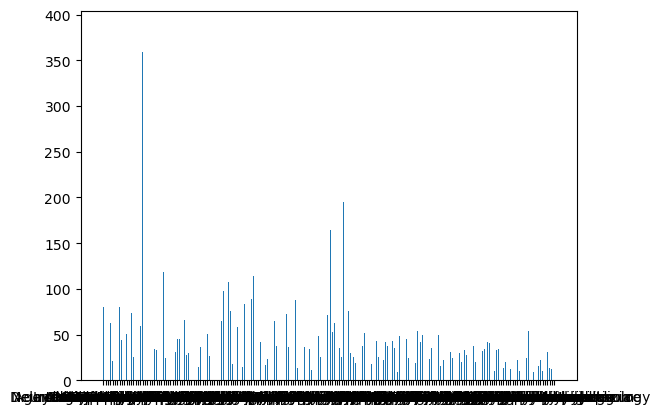

In [366]:
plt.hist(df_EnfeySinto_select.Sintoma,bins=800)

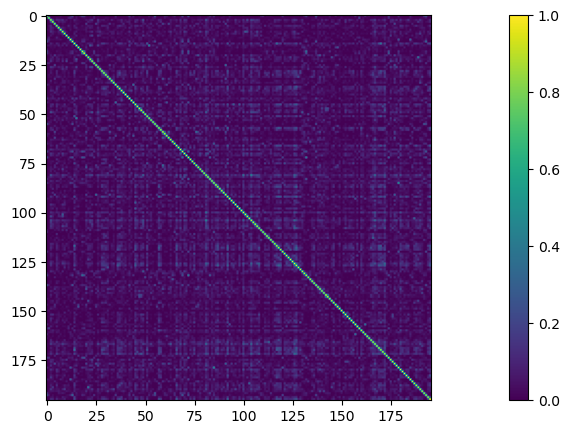

In [581]:

plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

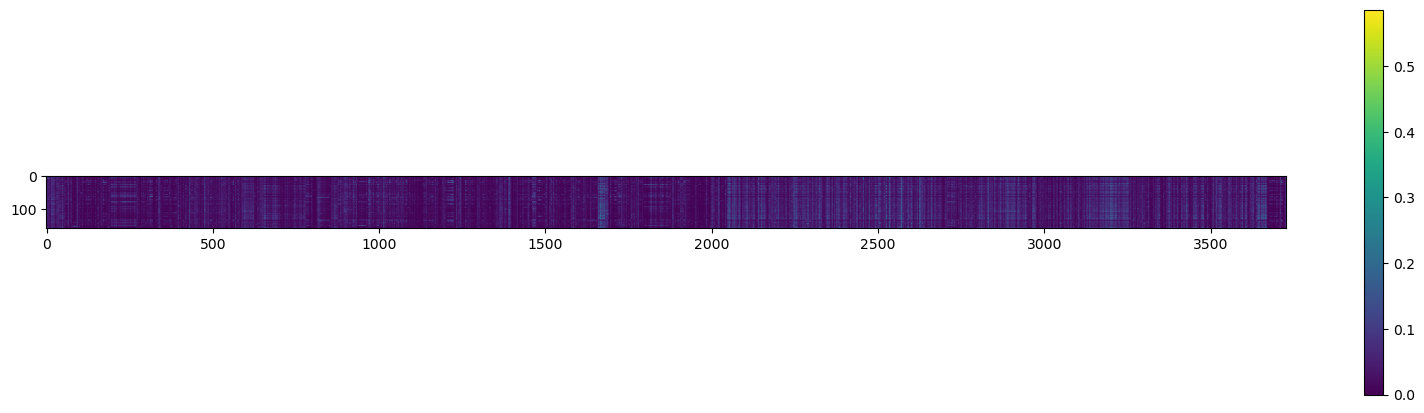

In [582]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [583]:

def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)
 


In [584]:
get_mse(users_predictions, ratings_train)
 


0.6153023603175983

In [585]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[156:196,:]
 
get_mse(users_predictions_test, ratings_test)

0.6695810950722689

In [ ]:
#item item

In [586]:
n_repos = ratings_train.shape[1]
n_repos

3728

In [587]:
neighbors = NearestNeighbors(n_neighbors=n_repos,
                         metric='cosine')
neighbors.fit(ratings_train.T)

NearestNeighbors(metric='cosine', n_neighbors=3728)

In [588]:

top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)
top_k_distances.shape

(3728, 3728)

In [589]:
top_k_items

array([[   0, 3328,  618, ..., 1291, 1322, 3727],
       [   1, 2405,  654, ..., 1413, 1402, 3727],
       [   2,  607,  817, ..., 1435, 1425, 3727],
       ...,
       [1252, 1995,  801, ..., 1272, 1274, 3727],
       [3676, 3726, 1283, ..., 1334, 1320, 3727],
       [1250, 3464, 3703, ..., 1253, 1255, 3726]])

In [590]:
SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data

,Sintoma
34,Cerebral cortical atrophy


In [591]:
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

34

In [ ]:
df_Sintomas[df_Sintomas['Sintoma'].isin([sintoma_ver])]

In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [ ]:

user0=item_preds.argsort()[sintoma_ver]
user0

# los tres con mayor puntaje en la predic para este usuario
for aRepo in user0[-3:]:
    selRepo = df_Enfermedades[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'], 'puntaje:', item_preds[usuario_ver][aRepo])

In [ ]:
#NO ME VALE!!! ESTÁS METIENDO ENFERMEDADES!!!  Y YO QUIERO METER SÍNTOMAS!!! NO ME VALE ITEM ITEM

In [592]:
df_transpuesta=df_train_generated

In [593]:
correlaciones = df_transpuesta.corr(method='pearson')
correlaciones

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
Sintoma,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.011893,-0.040770,-0.024832,-0.017995,-0.038436,-0.016381,0.009370,-0.027916,-0.025264,...,-0.017468,-0.027126,-0.022549,-0.028686,-0.031255,-0.030387,0.133330,0.241661,-0.016381,-0.027051
1,0.011893,1.000000,-0.034116,-0.018013,-0.020391,0.002690,-0.005254,-0.002576,-0.020250,-0.018326,...,-0.006226,-0.019677,-0.022919,-0.020809,-0.017974,-0.006960,0.002095,0.039359,-0.019531,-0.033480
2,-0.040770,-0.034116,1.000000,0.172076,-0.008278,0.080667,0.074300,0.066263,0.112414,0.007390,...,-0.007462,0.011467,0.061147,0.015645,0.123563,0.011969,-0.022233,-0.048411,0.003131,0.078694
3,-0.024832,-0.018013,0.172076,1.000000,-0.017890,-0.012901,0.063849,0.036738,0.060449,0.052818,...,-0.001893,0.014899,0.007687,0.149381,0.032753,0.034248,-0.019885,0.007742,0.031455,0.088017
4,-0.017995,-0.020391,-0.008278,-0.017890,1.000000,-0.027691,0.009344,-0.017890,0.021526,-0.002919,...,0.077844,-0.019542,-0.022763,-0.020667,0.002656,0.014100,-0.022510,-0.028935,-0.019397,-0.024572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-0.030387,-0.006960,0.011969,0.034248,0.014100,0.016570,0.049432,0.010877,-0.006308,-0.001615,...,0.036057,0.016506,0.006325,-0.017765,0.015907,1.000000,-0.030425,-0.031701,0.027818,0.039911
192,0.133330,0.002095,-0.022233,-0.019885,-0.022510,-0.030779,0.043386,0.022251,0.052917,0.021209,...,0.003063,-0.021722,-0.014156,-0.022971,-0.021806,-0.030425,1.000000,0.030156,0.004418,-0.036960
193,0.241661,0.039359,-0.048411,0.007742,-0.028935,-0.032235,-0.017448,-0.014460,-0.028735,-0.026005,...,0.011396,-0.027921,-0.032522,-0.029528,-0.039864,-0.031701,0.030156,1.000000,-0.027714,-0.041308


In [594]:
correlaciones[34].sort_values(ascending=False)

Sintoma
34     1.000000
190    0.194914
167    0.126941
126    0.118712
177    0.101500
         ...   
137   -0.024869
132   -0.025741
0     -0.029438
69    -0.029514
72    -0.033763
Name: 34, Length: 196, dtype: float64

In [595]:
Top = 3
# Top relaciones positivas
correlaciones[0].sort_values(ascending=False)[1:].head(Top)

Sintoma
55     0.265743
137    0.253828
193    0.241661
Name: 0, dtype: float64

In [596]:
# Top relaciones negativas
correlaciones[0].sort_values(ascending=True).head(Top)

Sintoma
81    -0.081252
104   -0.079709
172   -0.074395
Name: 0, dtype: float64

In [597]:
MediasUsers = df_transpuesta.mean(numeric_only=True,skipna=True)
MediasUsers

Sintoma
0      0.037554
1      0.020118
2      0.053648
3      0.015558
4      0.019850
         ...   
191    0.035676
192    0.024410
193    0.039700
194    0.018240
195    0.051770
Length: 196, dtype: float64

In [598]:
DesviacionesUsers = df_transpuesta.std(numeric_only=True,skipna=True)
DesviacionesUsers

Sintoma
0      0.190140
1      0.140423
2      0.225352
3      0.123774
4      0.139503
         ...   
191    0.185506
192    0.154339
193    0.195279
194    0.133837
195    0.221593
Length: 196, dtype: float64

In [599]:
df_ValoracionesNorm = df_transpuesta[MediasUsers.index].sub(MediasUsers, axis='columns')
df_ValoracionesNorm.sort_values(0).head(20)

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,0.98176,-0.05177
2467,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177
2468,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,0.964324,-0.02441,-0.0397,-0.01824,-0.05177
2469,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177
2470,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177
2471,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177
2472,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,0.98176,-0.05177
2473,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177
2474,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,-0.019313,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,0.94823
2475,-0.037554,-0.020118,-0.053648,-0.015558,-0.01985,-0.036481,-0.01824,-0.015558,-0.019582,-0.016094,...,0.980687,-0.018509,-0.024946,-0.020655,-0.037017,-0.035676,-0.02441,-0.0397,-0.01824,-0.05177


In [600]:
df_ValoracionesNorm = df_ValoracionesNorm.div(DesviacionesUsers, axis='columns')
df_ValoracionesNorm.sort_values(0).head(20)

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,7.335468,-0.233628
2467,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628
2468,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,5.198348,-0.158158,-0.203297,-0.136287,-0.233628
2469,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628
2470,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628
2471,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628
2472,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,7.335468,-0.233628
2473,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628
2474,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,-0.140315,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,4.279153
2475,-0.197506,-0.143267,-0.238063,-0.125696,-0.14229,-0.194555,-0.136287,-0.125696,-0.141306,-0.12788,...,7.124897,-0.137305,-0.15993,-0.145205,-0.196035,-0.192317,-0.158158,-0.203297,-0.136287,-0.233628


In [601]:
Numerador = df_ValoracionesNorm.dot(correlaciones)
Numerador.sort_values(0,ascending=False)

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
1220,14.640603,1.303038,-2.434289,-1.050654,-0.862672,-2.164168,-0.698321,0.575205,-0.958483,-1.547265,...,0.382053,-1.321991,-2.260056,-1.843409,-2.271913,-1.526530,4.300583,7.632376,-1.488732,-3.166297
1260,14.522497,2.465606,-3.853004,-1.583155,-0.964882,-2.280206,-1.443151,0.317986,-2.700564,-2.254039,...,-0.134734,-2.412020,-3.162815,-2.310527,-2.988563,-1.692711,2.329964,14.035664,-2.543265,-3.773253
1032,14.375750,0.835229,-3.009280,-1.014261,0.179070,-2.385255,-0.985678,0.951751,-1.096552,-1.871703,...,2.723115,-1.103357,-2.807246,-2.067602,-2.773837,-1.032733,4.506233,9.332879,-2.264400,-3.518760
1432,13.783020,1.629847,-2.163319,-0.512799,-0.574505,-2.415230,-0.764179,0.442954,-0.693523,-1.137441,...,0.936690,-1.085168,-1.925057,-1.673358,-1.435866,-1.348567,4.292651,13.685659,-1.303945,-2.727286
1898,13.731308,2.259801,-3.117114,-1.604854,-1.345389,-1.935524,-1.547582,0.751153,-2.145072,-1.714805,...,-0.137517,-1.914279,-2.753829,-1.999667,-2.751873,-1.513159,3.398530,6.350474,-1.805574,-3.283768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,-4.863408,-2.587686,5.218397,2.668775,-2.060991,6.242805,0.981636,-1.686277,1.098268,3.656234,...,-1.480278,4.706399,16.767291,5.293336,5.570232,3.353597,-2.533313,-4.789989,5.730561,11.070249
2255,-4.881099,-3.467559,4.622356,3.589597,-2.787834,6.018250,3.948444,-1.928443,4.119041,4.810994,...,0.643412,6.858365,11.878658,7.161437,6.780664,2.913875,-1.472019,-4.734407,8.917790,14.705468
1665,-4.963299,-3.276946,4.181537,1.262058,-2.207706,11.979939,1.341676,-2.213408,1.546518,4.780166,...,-1.457391,5.658835,18.004059,6.581678,6.387177,2.102051,-3.002647,-4.722296,7.282645,12.981124
2199,-5.118000,-3.001079,5.590364,2.223781,-1.678583,4.809675,2.118986,-0.762110,3.308393,5.198665,...,-1.528365,4.737959,14.579011,4.621489,12.316409,7.968562,-2.488244,-4.989177,6.124927,11.088297


In [602]:
Denominador = correlaciones.abs().sum()
Denominador

Sintoma
0       9.164981
1       5.270759
2       9.151622
3       6.502315
4       6.580396
         ...    
191     5.746095
192     6.166998
193     8.598042
194     8.278377
195    11.737435
Length: 196, dtype: float64

In [603]:
Cociente = Numerador.div(Denominador, axis='columns')
Cociente.sort_values(0,ascending=False)

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
1220,1.597450,0.247220,-0.265995,-0.161582,-0.131097,-0.288279,-0.131673,0.135120,-0.125657,-0.243533,...,0.067613,-0.174765,-0.228512,-0.246237,-0.266065,-0.265664,0.697354,0.887688,-0.179834,-0.269761
1260,1.584564,0.467790,-0.421019,-0.243476,-0.146630,-0.303736,-0.272116,0.074697,-0.354044,-0.354776,...,-0.023844,-0.318865,-0.319789,-0.308633,-0.349992,-0.294585,0.377812,1.632426,-0.307218,-0.321472
1032,1.568552,0.158465,-0.328825,-0.155985,0.027213,-0.317729,-0.185856,0.223574,-0.143758,-0.294598,...,0.481920,-0.145862,-0.283837,-0.276184,-0.324845,-0.179728,0.730701,1.085466,-0.273532,-0.299790
1432,1.503879,0.309224,-0.236386,-0.078864,-0.087306,-0.321722,-0.144091,0.104054,-0.090921,-0.179028,...,0.165770,-0.143457,-0.194640,-0.223522,-0.168155,-0.234693,0.696068,1.591718,-0.157512,-0.232358
1898,1.498236,0.428743,-0.340608,-0.246813,-0.204454,-0.257823,-0.291807,0.176452,-0.281219,-0.269903,...,-0.024337,-0.253064,-0.278437,-0.267110,-0.322273,-0.263337,0.551083,0.738595,-0.218107,-0.279769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,-0.530651,-0.490951,0.570215,0.410435,-0.313202,0.831577,0.185094,-0.396120,0.143983,0.575476,...,-0.261970,0.622178,1.695322,0.707068,0.652333,0.583631,-0.410785,-0.557102,0.692232,0.943157
2255,-0.532581,-0.657886,0.505086,0.552049,-0.423657,0.801665,0.744507,-0.453007,0.540006,0.757230,...,0.113867,0.906664,1.201038,0.956603,0.794087,0.507105,-0.238693,-0.550638,1.077239,1.252869
1665,-0.541550,-0.621722,0.456918,0.194094,-0.335497,1.595796,0.252982,-0.519947,0.202748,0.752378,...,-0.257920,0.748088,1.820370,0.879161,0.748005,0.365823,-0.486890,-0.549229,0.879719,1.105959
2199,-0.558430,-0.569383,0.610860,0.341998,-0.255088,0.640676,0.399550,-0.179026,0.433730,0.818248,...,-0.270481,0.626350,1.474067,0.617325,1.442381,1.386779,-0.403477,-0.580269,0.739870,0.944695


In [604]:
Valoraciones = Cociente.mul(DesviacionesUsers,axis='columns').add(MediasUsers, axis='columns')
Valoraciones.sort_values(0,ascending=False)

Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
1220,0.341292,0.054833,-0.006295,-0.004442,0.001561,-0.017574,0.000618,0.032282,0.002169,-0.014556,...,0.028620,-0.005050,-0.010697,-0.014371,-0.013224,-0.013606,0.132039,0.213046,-0.005828,-0.008007
1260,0.338842,0.085806,-0.041229,-0.014578,-0.000605,-0.020472,-0.018179,0.024804,-0.029480,-0.028556,...,0.016031,-0.024474,-0.024935,-0.023247,-0.029072,-0.018971,0.082721,0.358477,-0.022877,-0.019465
1032,0.335798,0.042370,-0.020453,-0.003749,0.023646,-0.023096,-0.006634,0.043231,-0.000340,-0.020982,...,0.085646,-0.001154,-0.019327,-0.018631,-0.024323,0.002335,0.137185,0.251668,-0.018368,-0.014661
1432,0.323501,0.063540,0.000378,0.005797,0.007670,-0.023845,-0.001044,0.028437,0.006982,-0.006437,...,0.042130,-0.000829,-0.005414,-0.011140,0.005265,-0.007861,0.131840,0.350528,-0.002841,0.000282
1898,0.322428,0.080323,-0.023109,-0.014991,-0.008672,-0.011863,-0.020814,0.037398,-0.019389,-0.017874,...,0.015964,-0.015604,-0.018485,-0.017340,-0.023837,-0.013175,0.109463,0.183931,-0.010951,-0.010224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,-0.063344,-0.048823,0.182147,0.066359,-0.023843,0.192408,0.043013,-0.033471,0.039534,0.088521,...,-0.016745,0.102378,0.289387,0.121231,0.160197,0.143943,-0.038990,-0.069091,0.110887,0.260767
2255,-0.063711,-0.072264,0.167470,0.083887,-0.039252,0.186799,0.117883,-0.040513,0.094413,0.111396,...,0.034986,0.140726,0.212287,0.156725,0.186964,0.129747,-0.012430,-0.067828,0.162415,0.329397
1665,-0.065417,-0.067186,0.156615,0.039582,-0.026953,0.335705,0.052099,-0.048798,0.047678,0.110785,...,-0.016187,0.119350,0.308892,0.145710,0.178262,0.103538,-0.050736,-0.067553,0.135980,0.296843
2199,-0.068626,-0.059836,0.191307,0.057888,-0.015736,0.156613,0.071715,-0.006601,0.079686,0.119076,...,-0.017916,0.102940,0.254875,0.108465,0.309381,0.292932,-0.037862,-0.073615,0.117263,0.261108


In [658]:
a=Valoraciones[34].sort_values(ascending=False).head(10)

In [672]:
a.reset_index()

,index,34
0,2829,0.321575
1,2112,0.297769
2,2199,0.283219
3,2241,0.278390
4,1013,0.271843
5,680,0.268496
6,2108,0.268254
7,2189,0.262100
8,2324,0.261098
9,1504,0.257684


In [656]:
j=0
while (j<len(a)):
    print (a["index"][j])
    j=j+1


2829
2112
2199
2241
1013
680
2108
2189
2324
1504


In [ ]:
#34	Cerebral cortical atrophy

In [522]:
df_Enfermedades.loc[2829]["Enfermedad"]

'Síndrome de deleción 1p36'

In [699]:
def aparece_y_como (scoring_enfermedades,id_Sintoma):
    scoring_enfermedades=scoring_enfermedades.reset_index() 
    j=0
    frecuencias=[]
    while (j<len(scoring_enfermedades)):
     
        id_enfermedad=scoring_enfermedades["index"][j]
        lista=df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]==
                                   df_Enfermedades.loc[id_enfermedad][1]]
        lista=lista.reset_index()
        sintoma= df_Sintomas.loc[id_Sintoma].Sintoma
        
        i=0
        while i<len(lista):
         
            if lista["Sintoma"][i]==sintoma:
                frecuencias.append(lista["Frecuencia"][i])
               
            i=i+1  
        j=j+1
    return frecuencias

In [700]:
lista=aparece_y_como (a,34)
lista

['Muy frecuente (99-80%)',
 'Muy frecuente (99-80%)',
 'Frecuente (79-30%)',
 'Frecuente (79-30%)',
 'Muy frecuente (99-80%)',
 'Frecuente (79-30%)',
 'Frecuente (79-30%)',
 'Muy frecuente (99-80%)',
 'Frecuente (79-30%)',
 'Frecuente (79-30%)']

In [701]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]==df_Enfermedades.loc[2199]["Enfermedad"]] 

,Enfermedad,Sintoma,Frecuencia
62268,Síndrome de Aymé-Gripp,Intellectual disability,Muy frecuente (99-80%)
62269,Síndrome de Aymé-Gripp,Global developmental delay,Muy frecuente (99-80%)
62270,Síndrome de Aymé-Gripp,Postnatal growth retardation,Muy frecuente (99-80%)
62272,Síndrome de Aymé-Gripp,Cryptorchidism,Frecuente (79-30%)
62273,Síndrome de Aymé-Gripp,Narrow mouth,Frecuente (79-30%)
62274,Síndrome de Aymé-Gripp,Cleft palate,Frecuente (79-30%)
62275,Síndrome de Aymé-Gripp,Thin upper lip vermilion,Frecuente (79-30%)
62276,Síndrome de Aymé-Gripp,Hydrocephalus,Frecuente (79-30%)
62278,Síndrome de Aymé-Gripp,Brachycephaly,Frecuente (79-30%)
62279,Síndrome de Aymé-Gripp,Hypertelorism,Frecuente (79-30%)


In [629]:
sintoma= df_Sintomas.loc[34]
sintoma.Sintoma

'Cerebral cortical atrophy'

In [ ]:
save_to_csv(df_train_generated,"../data/01_raw/df_trained_Ofi.csv")

In [ ]:
#df_train_generated=pd.read_csv("../data/01_raw/df_trained_Ofi.csv")

In [ ]:
df_enfermedades= load_from_csv("../data/01_raw/exportCSVfromXML_Ofi.csv")

In [ ]:
save_to_csv(df_enfermedades,"../data/01_raw/exportCSVfromXML_Ofi.csv")

In [ ]:


sim_matrix.shape

In [ ]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [ ]:
sim_matrix_train

In [ ]:
users_predictions.shape

In [ ]:
ratings_train

In [ ]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [ ]:
df_Enfermedades

In [ ]:
df_Sintomas.drop (["Enfermedad", "Frecuencia", "Id_Enfermedad"], axis=1)

In [ ]:
user0=users_predictions.argsort()[sintoma_ver]
user0

In [ ]:
rows=df_matrix.index
rows[sintoma_ver]

In [ ]:
df_matrix.iloc["id"]

In [ ]:
df_enfermedades_select[(df_enfermedades_select["Sintoma"]==SINTOMA_EJEMPLO) &
               (df_enfermedades_select["Enfermedad"]=="Aciduria 3-metilglutacónica tipo 1")]

In [ ]:
df_enfermedades_select

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)
top_k_distances.shape

In [ ]:
data = df_repos[df_repos['title'] == 'jbagnato / machine-learning']
repo_ver = data.iloc[0]['repoId'] -1
#print(repo_ver)

In [ ]:
SINTOMA_EJEMPLO = 'Ataxia' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data.iloc[0]
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

In [ ]:
df_Sintomas[df_Sintomas['repoId'].isin([sintoma_ver])]


In [ ]:
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [360]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [361]:
get_mse(users_predictions, ratings_train)

0.455185243370508

In [362]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[50:63,:]

get_mse(users_predictions_test, ratings_test)

IndexError: index 13 is out of bounds for axis 0 with size 13

In [ ]:
neighbors = NearestNeighbors(1, 'cosine')
neighbors.fit(ratings_train.T)

In [ ]:
df_train_generated,model,target,X_test,y_test, X_train, y_train=train_data (df_train_generated)  

In [ ]:
evaluate (model, X_test, y_test)

model

In [ ]:
model

In [ ]:
import pickle

#pickle.dump(model,open("modelo19m.pickle","wb"))
model2=pickle.load(open("modelo19m.pickle","rb"))

In [ ]:
df_train_generated.to_csv("df_train_final.csv", index=False)

In [ ]:
from joblib import dump
dump(model, 'modelo19m.joblib') 

In [ ]:
from joblib import load
new_model = load('modelo19m.joblib')

In [ ]:
evaluate (new_model, X_test, y_test)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
X_test

In [ ]:
X_test.iloc[[1]]

In [ ]:
model.predict(X_test.iloc[[2]])

In [ ]:
y_test.iloc[[2]]

In [ ]:
predicciones = model.predict_proba(X_test.iloc[[2]])
predicciones.shape


In [ ]:
X_test.iloc[[2]]


In [ ]:
a=df_train_generated.columns


In [ ]:
b=a.to_list()
b.remove('id_Enfermedad')
b

In [ ]:
df_train_generated.columns
df_predicciones = pd.DataFrame(data=predicciones)
#df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones

In [ ]:
df_predicciones2=df_predicciones.transpose()
df_predicciones2

In [ ]:
list_to_rank=df_predicciones2[df_predicciones2[0]>0]

In [ ]:
rank = list_to_rank.sort_values(0,ascending=False)
rank

In [ ]:
rank2=rank.reset_index()

In [ ]:
rank2=rank2.head(5)
rank2

In [ ]:
rank2.merge (data)

In [ ]:
rank2["Enfermedad"]= rank2.apply(lambda row:
                                 data[data['Id_Enfermedad']==row["index"]].iloc[0][0]
                                 if data['Id_Enfermedad']==row["index"]
                                 else 0,
                                 axis=1
                                )

In [ ]:
data.iloc[0][0]

In [ ]:
for i in range(1):
    
    a=data[data['Id_Enfermedad']==rank2["index"][i]].iloc[0][0]
    a

In [ ]:
a

In [ ]:
a.iloc[0][0]

In [ ]:
list_rank=rank.to_numpy().tolist()
list_rank


In [ ]:
for i in range(5):
    print (i)
    print (lis)
        

In [ ]:
data[data['Id_Enfermedad']==2389]

#### 